# Rami's Math Quest: Day 3: 2D to 1D Orthographic Projection

Welcome here! Glad you've picked up some interest and reading this :)

This is a quest I've started personally to help myself understand some math concepts more.
And at the same time, it might inspire others to follow a similar path or even pick up some value by reading those notebooks.

If you don't already do, you can follow me on [LinkedIn], [Twitter], [Mastodon] and/or [Telegram].

[LinkedIn]: https://www.linkedin.com/in/rami-sabbagh-2001/
[Twitter]: https://twitter.com/rami_sab07
[Mastodon]: https://mastodon.social/@rami01
[Telegram]: https://t.me/rami_sab07_blog

Due to my limited time, I won't be able to explain everything in this notebook and make it beginner friendly like a course material.

Instead it would be more like a diary log of the stuff I went in while trying some concepts.
However I'll try to provide some links to resources and some explanation where I find suitable.

Generally I expect the reader to:
- Not have trouble reading English text.
- Use Google for the words, terminology and concepts they don't know.
- Know how to use a jupyter notebook.
- Have some basic knowledge of Python, NumPy and matplotlib.

## In this notebook

I'm going to explore projecting 2D space into a 1D space, specifically the orthographic projection.

In [1]:
from math import sqrt, sin, cos, pi

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from matplotlib import ticker, rc
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

rc('figure', dpi=120)
rc('animation', html='html5') # replace with `%matplotlib widget` when running locally for a better experience.

Shapes will be defined as a sequence of vertices stored as a 2-dimensional array,
for the demonstration purposes the shape will be a simple arrow.

In [2]:
demo_shape = np.array([
    # X,   Y, 1
    [ 0,   0, 1],
    [-1,   1, 1],
    [-1,  .4, 1],
    [-3,  .4, 1],
    [-3, -.4, 1],
    [-1, -.4, 1],
    [-1,  -1, 1],
    [ 0,   0, 1],
]);

The plots code might not be so appealing to read and understand. And you don't really have to do so.

In fact they're written using trial and error until something works.
And not much effort is spent on making them look clean,
because the focus is on the mathematical side of the things.

I'll try to wrap the plots code in functions in-order to keep the maths out of them,
but plots are not always easy to abstract, sometimes (especially in animations) i'll have the math code somewhere within the plot code.
You'll have to dig in them in such cases, sorry for that.

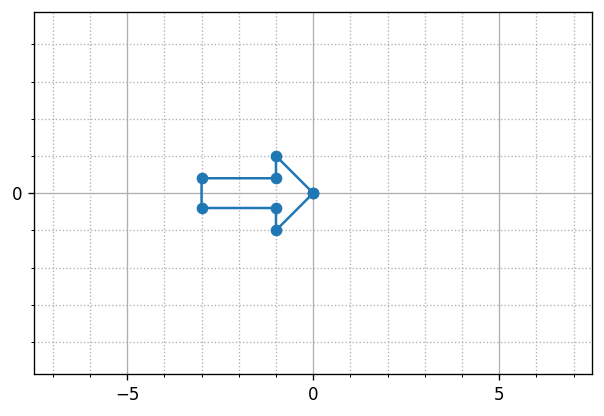

In [3]:
def plot_shape(vertices: npt.NDArray):
    fig, ax = plt.subplots()

    X = vertices[:, 0]
    Y = vertices[:, 1]

    ax.plot(X, Y, marker='o')

    ax.axis('equal')
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-5, 5)

    ax.set_axisbelow(True); # draw the grid under everything else
    ax.grid(True, which='major', linestyle='-')
    ax.grid(True, which='minor', linestyle=':')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

plot_shape(demo_shape)

Next are the basic geometrical transformation matrices, as they have been made in the previous notebook (#01).

In [4]:
def translation_matrix(deltaX: float = 0, deltaY: float = 0) -> npt.NDArray:
    mat = np.identity(3)
    mat[2, 0] = deltaX
    mat[2, 1] = deltaY
    return mat

def scaling_matrix(scaleX: float = 1, scaleY: float = 1) -> npt.NDArray:
    mat = np.identity(3)
    mat[0, 0] = scaleX
    mat[1, 1] = scaleY
    return mat

def shearing_matrix(shearX: float = 0, shearY: float = 0) -> npt.NDArray:
    mat = np.identity(3)
    mat[0, 1] = shearX
    mat[1, 0] = shearY
    return mat

def rotation_matrix(theta: float) -> npt.NDArray:
    return np.array([
        [ cos(theta),  sin(theta), 0],
        [-sin(theta),  cos(theta), 0],
        [          0,           0, 1],
    ]);

Make sure they all work as expected.

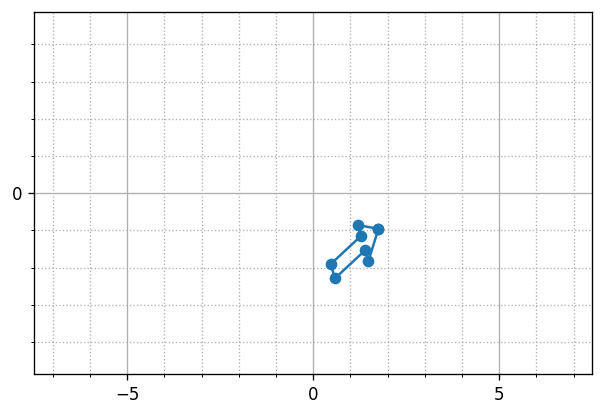

In [5]:
plot_shape(demo_shape
    @ shearing_matrix(.5, 0)
    @ scaling_matrix(.5, .5)
    @ rotation_matrix(.25 * pi)
    @ translation_matrix(2, 0)
    @ rotation_matrix(-.5)
    )

## Orthogonal Projection

Now into the actual objective of this notebook: Orthogonal projection.

In the 2D space, projecting into the X axis using linear algebra is as simple as just taking the X component of each vector and setting the other components to 0.

Here I've implemented it using a scaling matrix, where the Y component is squashed out by being scaled to 0.

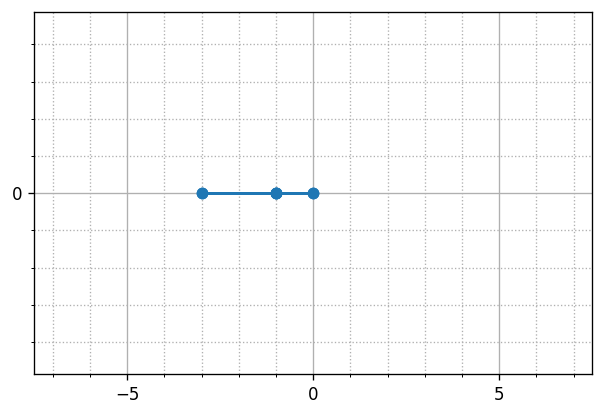

In [6]:
def orthographic_projection_matrix() -> npt.NDArray:
    return scaling_matrix(1, 0)

plot_shape(demo_shape @ orthographic_projection_matrix())

## Creating a fancy animation for demonstration

_`create_line` is a utility method made to help with the plots. used for drawing the line where the shape is projected into._

In [7]:
def create_line(center_x: float, center_y: float, angle: float, length: float) -> npt.NDArray:
    return np.array([
        [ .5,  0,  1],
        [-.5,  0,  1],
    ]) @ scaling_matrix(length, 1) @ rotation_matrix(angle) @ translation_matrix(center_x, center_y)

### Prototyping the animation first using a static plot

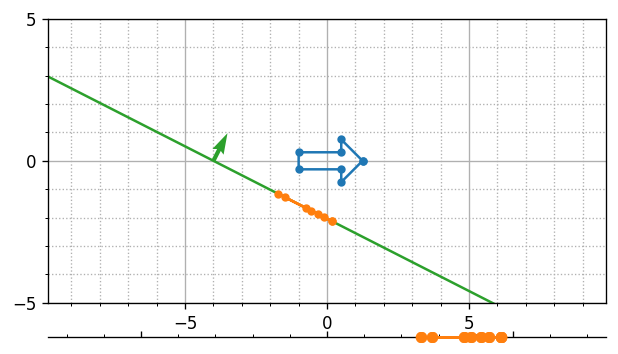

In [8]:
def plot_orthographic_projection(shape: npt.NDArray, camera_x: float, camera_y: float, camera_angle: float):
    fig = plt.figure()
    grid = GridSpec(10, 1, hspace=3)

    ax = fig.add_subplot(grid[:-2, :])
    subview_ax = fig.add_subplot(grid[-2, :])

    # Projection Line
    projection_line = create_line(camera_x, camera_y, camera_angle, 30)
    ax.plot(projection_line[:,0], projection_line[:,1], color='C2')
    ax.quiver([camera_x], [camera_y], [cos(camera_angle+pi*.5)], [sin(camera_angle+pi*.5)], color='C2')

    # Original Shape
    ax.plot(shape[:, 0], shape[:, 1], marker='o', markersize=4)

    # Projected Shape
    shape_shadow = (shape
        @ translation_matrix(-camera_x, -camera_y)
        @ rotation_matrix(-camera_angle)

        @ orthographic_projection_matrix()
        
        @ rotation_matrix(camera_angle)
        @ translation_matrix(camera_x, camera_y)
    )
    ax.plot(shape_shadow[:, 0], shape_shadow[:, 1], marker='o', markersize=4)

    # Projected Shape on the independent axis
    subview_shape = (shape
        @ translation_matrix(-camera_x, -camera_y)
        @ rotation_matrix(-camera_angle)
        @ orthographic_projection_matrix()
    )
    subview_ax.plot(subview_shape[:, 0], subview_shape[:, 1], marker='o', color='C1', zorder=10)

    # -- Style Options -- #

    ax.axis('equal')
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-5, 5)
    
    ax.set_axisbelow(True); # draw the grid under everything else
    ax.grid(True, which='major', linestyle='-')
    ax.grid(True, which='minor', linestyle=':')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

    subview_ax.set_xlim(-7.5, 7.5)
    subview_ax.set_yticks([])
    subview_ax.spines['bottom'].set_position('center')
    subview_ax.spines['bottom'].set_zorder(0)
    subview_ax.spines['top'].set_visible(False)
    subview_ax.spines['left'].set_visible(False)
    subview_ax.spines['right'].set_visible(False)

    subview_ax.xaxis.set_tick_params(which='both', direction='in')
    subview_ax.xaxis.set_major_formatter(ticker.NullFormatter())
    subview_ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    subview_ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plot_orthographic_projection(demo_shape @ scaling_matrix(.75, .75) @ translation_matrix(1.25, 0), -4, 0, -.15 * pi)

### Now adapt the static plot into an animation

For the math code, look for the `animate` method.

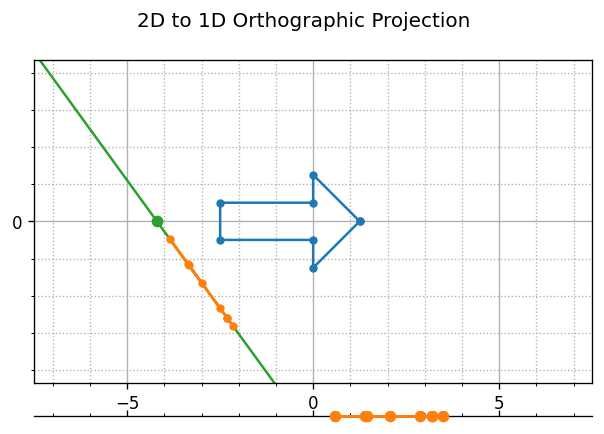

In [9]:
def render_animation():
    animation_length = 20
    animation_fps = 30

    fig = plt.figure()
    fig.suptitle("2D to 1D Orthographic Projection")
    grid = GridSpec(10, 1, hspace=2.4)

    ax = fig.add_subplot(grid[:-1, :])
    subview_ax = fig.add_subplot(grid[-1, :])

    # Projection Line
    projection_line_plot, = ax.plot([], [], color='C2')
    projection_line_center, = ax.plot([], [], color='C2', marker='o')

    # Original Shape
    shape_plot, = ax.plot([], [], marker='o', markersize=4)

    # Projected Shape
    shadow_plot, = ax.plot([], [], marker='o', markersize=4)

    # Projected Shape on the independent axis
    subview_plot, = subview_ax.plot([], [], marker='o', color='C1', zorder=10)

    # -- Style Options -- #

    ax.axis('equal')
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-5, 5)
    
    ax.set_axisbelow(True); # draw the grid under everything else
    ax.grid(True, which='major', linestyle='-')
    ax.grid(True, which='minor', linestyle=':')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

    subview_ax.set_xlim(-7.5, 7.5)
    subview_ax.set_yticks([])
    subview_ax.spines['bottom'].set_position('center')
    subview_ax.spines['bottom'].set_zorder(0)
    subview_ax.spines['top'].set_visible(False)
    subview_ax.spines['left'].set_visible(False)
    subview_ax.spines['right'].set_visible(False)

    subview_ax.xaxis.set_tick_params(which='both', direction='in')
    subview_ax.xaxis.set_major_formatter(ticker.NullFormatter())
    subview_ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    subview_ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    shape = demo_shape @ scaling_matrix(1.25, 1.25) @ translation_matrix(1.25, 0)

    def init():
        shape_plot.set_data(shape[:,0], shape[:,1])
        return projection_line_plot, projection_line_center, shape_plot, shadow_plot, subview_plot,
    
    def animate(i): # i is a float that goes from 0 (the start of the animation) to 2 (the end of the animation).
        camera_x = 4.2*cos(i*2*pi + pi)
        camera_y = 3.4*sin(i*2*pi + pi)
        camera_angle = i*2*pi - pi * .3

        projection_line = create_line(camera_x, camera_y, camera_angle, 30)
        projection_line_plot.set_data(projection_line[:,0], projection_line[:,1])
        projection_line_center.set_data([camera_x], [camera_y])

        shape_shadow = (shape
            @ translation_matrix(-camera_x, -camera_y)
            @ rotation_matrix(-camera_angle)
            @ orthographic_projection_matrix()
            @ rotation_matrix(camera_angle)
            @ translation_matrix(camera_x, camera_y)
        )
        shadow_plot.set_data(shape_shadow[:,0], shape_shadow[:,1])

        subview_shape = (shape
            @ translation_matrix(-camera_x, -camera_y)
            @ rotation_matrix(-camera_angle)
            @ orthographic_projection_matrix()
        )
        subview_plot.set_data(subview_shape[:,0], subview_shape[:,1])

        return projection_line_plot, projection_line_center, shape_plot, shadow_plot, subview_plot,

    anim = FuncAnimation(
        fig, animate, init_func=init,
        frames=np.linspace(0, 2, animation_fps * animation_length), interval=int(1000 / animation_fps), blit=True,
    )

    return anim

anim = render_animation()
anim

In [10]:
# anim.save('2d-to-1d-orthographic-projection.mp4', writer='ffmpeg')

That's it!
Hope you learned something :)

~Rami Sabbagh, 2023-03-25